In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas.util.testing as tm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
url = "https://raw.githubusercontent.com/marianaav26/FisicaComputacional1/master/Actividad1/diarios.txt"


#Asignamos nombres a las columnas
columnas = ['Fecha','Precip','Evap','Tmax','Tmin']

df_clima = pd.read_csv(url, names=columnas, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
df_cp0 = df_clima.copy()

df_c1 = df_cp0.replace(to_replace = 'Nulo',value = '', regex = True)

#cambiamos los datos a valor numerico
for i in columnas[1:]:
  df_c1[i] = pd.to_numeric(df_c1[i], errors = 'coerce')

df_c2 = df_c1.copy()
df_c2['Fecha'] = pd.to_datetime(df_clima['Fecha'], dayfirst = True)

df_c2['Año'] = df_c2['Fecha'].dt.year
df_c2['Mes'] = df_c2['Fecha'].dt.month

dat_meteor = df_c2.copy()


dat_meteor.drop("Mes", axis=1, inplace=True)
dat_meteor['Mes'] = dat_meteor['Fecha'].dt.strftime('%b')

#Fecha como indice
dat_meteorTS = dat_meteor.copy()
dat_meteorTS = dat_meteorTS.set_index('Fecha')
dat_meteorTS.info()

#Seleccion de un conjunto de 30 años, haciendo un conjunto de series de tiempo
dat_metTS1 = dat_meteorTS[(dat_meteorTS['Año'] >= 1960) & (dat_meteorTS['Año'] <= 1977)]
dat_metTS2 = dat_meteorTS[(dat_meteorTS['Año'] >= 1978) & (dat_meteorTS['Año'] <= 1990)]
dat_metTS3 = dat_meteorTS[(dat_meteorTS['Año'] >= 1991) & (dat_meteorTS['Año'] <= 2015)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15501 entries, 1961-04-10 to 2016-03-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  15485 non-null  float64
 1   Evap    8623 non-null   float64
 2   Tmax    15104 non-null  float64
 3   Tmin    15106 non-null  float64
 4   Año     15501 non-null  int64  
 5   Mes     15501 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 847.7+ KB


In [ ]:
 #Probaremos la estacionaridad de una serie de tiempo
 def test_stationarity(sTiempo):
   
    #Determinar la Estadística de promedios móviles
    promMov = sTiempo.rolling(window=365, center=True).mean()
    stdMov = sTiempo.rolling(window=365, center=True).std() 
    
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(sTiempo, color='green',label='Original')
    plt.plot(promMov, color='red', label='Promedio móvil')
    plt.plot(stdMov, color='black', label = 'Desviación estándar móvil')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(sTiempo, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Valor critico (%s)'%key] = value
    print(dfoutput)

# Ejercicio 1

In [ ]:
#primera serie de tiempo, con fechas de inicio y fin como filtro de informacion
start, end= '1981-01', '1984-12'
TS = dat_metTS2.loc[start:end].copy()
TS.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
1981-01-01,0.0,2.9,29.0,5.5,1981,Jan
1981-01-02,0.0,3.3,27.0,4.0,1981,Jan
1981-01-03,0.0,3.2,26.0,5.5,1981,Jan
1981-01-04,0.0,2.0,24.5,7.5,1981,Jan
1981-01-05,0.0,2.1,24.0,7.5,1981,Jan


In [ ]:
#Serie de tiempo para las temperaturas max y min
ts_Tmax = TS['Tmax'].copy()
ts_Tmin = TS['Tmin'].copy()

print(ts_Tmax.head())
print(ts_Tmin.head())

Fecha
1981-01-01    29.0
1981-01-02    27.0
1981-01-03    26.0
1981-01-04    24.5
1981-01-05    24.0
Name: Tmax, dtype: float64
Fecha
1981-01-01    5.5
1981-01-02    4.0
1981-01-03    5.5
1981-01-04    7.5
1981-01-05    7.5
Name: Tmin, dtype: float64


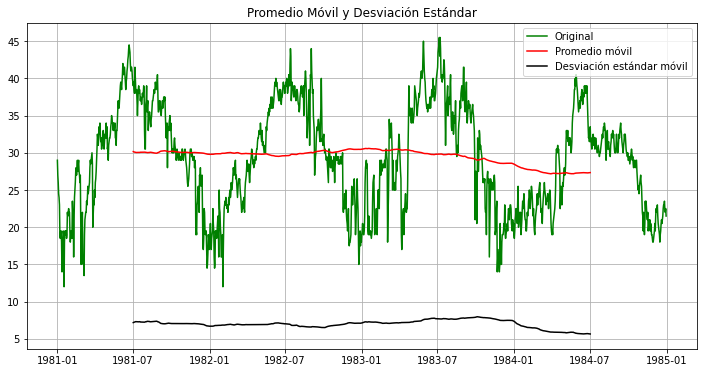

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.661315
p-value                           0.080975
#Lags Used                       23.000000
Number of Observations Used    1437.000000
Valor critico (1%)               -3.434909
Valor critico (5%)               -2.863553
Valor critico (10%)              -2.567842
dtype: float64


In [ ]:
test_stationarity(ts_Tmax)

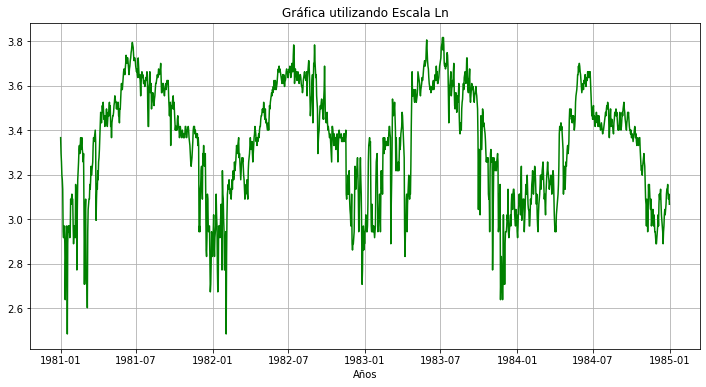

In [ ]:
Periodo_prueba_ln = np.log(ts_Tmax)
plt.plot(Periodo_prueba_ln, color='green')
plt.xlabel('Años',color='black')
plt.title('Gráfica utilizando Escala Ln')
plt.grid()
plt.show();

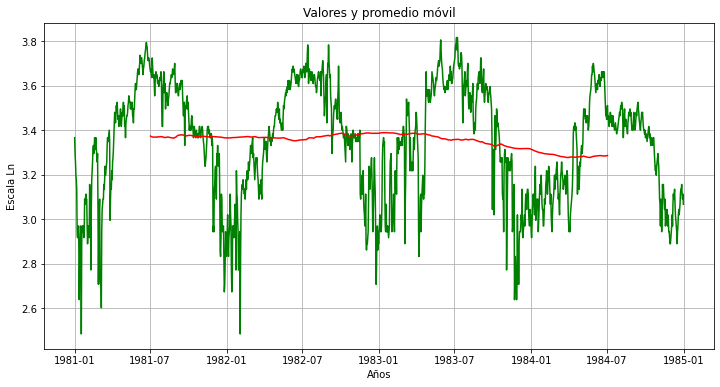

In [ ]:
Promedio_movil = Periodo_prueba_ln.rolling(365, center=True).mean()
plt.plot(Periodo_prueba_ln, color='green')
plt.plot(Promedio_movil, color='red')
plt.xlabel('Años', color='black')
plt.ylabel('Escala Ln', color = 'black')
plt.title('Valores y promedio móvil')
plt.grid()
plt.show()

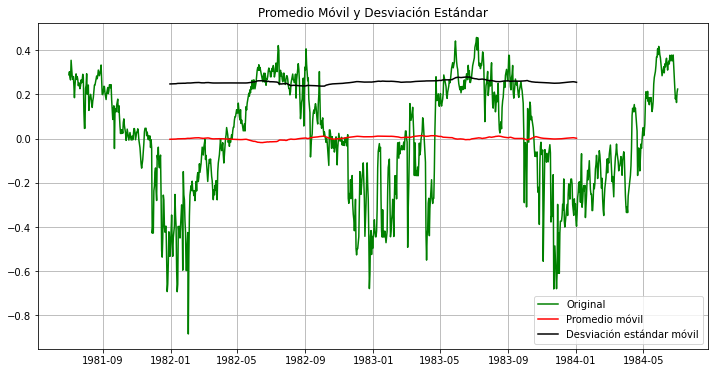

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.252789
p-value                           0.187647
#Lags Used                       22.000000
Number of Observations Used    1074.000000
Valor critico (1%)               -3.436453
Valor critico (5%)               -2.864235
Valor critico (10%)              -2.568205
dtype: float64


In [ ]:
Periodo_prueba_ln_moving_ave_diff = Periodo_prueba_ln - Promedio_movil
Periodo_prueba_ln_moving_ave_diff.dropna(inplace=True)
#Estacionaridad para la serie de tiempo en Log.
test_stationarity(Periodo_prueba_ln_moving_ave_diff)

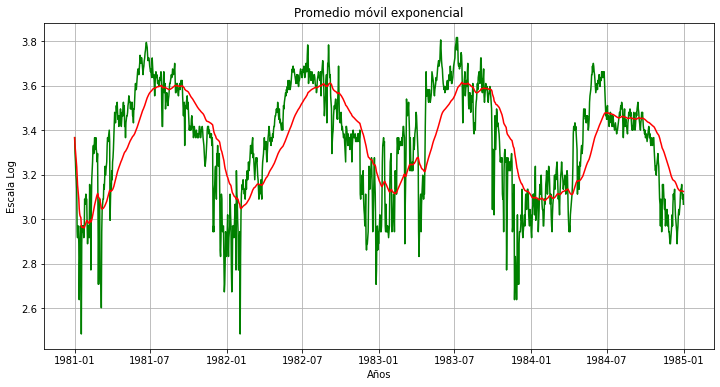

In [ ]:
EWM_avg = Periodo_prueba_ln.ewm(halflife=30).mean()#30 DÍAS
plt.plot(Periodo_prueba_ln, color='green')
plt.plot(EWM_avg, color = 'red')
plt.xlabel('Años', color='black')
plt.ylabel('Escala Log', color='black')
plt.title('Promedio móvil exponencial')
plt.grid()
plt.show()


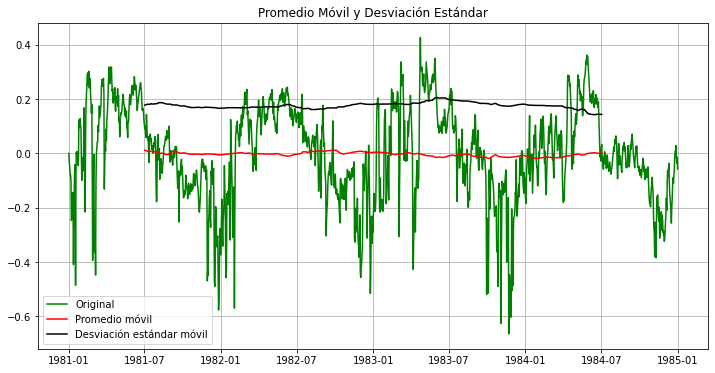

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.204127
p-value                           0.019747
#Lags Used                       24.000000
Number of Observations Used    1436.000000
Valor critico (1%)               -3.434912
Valor critico (5%)               -2.863555
Valor critico (10%)              -2.567843
dtype: float64


In [ ]:
Periodo_prueba_ln_EWM_avg_diff = Periodo_prueba_ln - EWM_avg
test_stationarity(Periodo_prueba_ln_EWM_avg_diff)

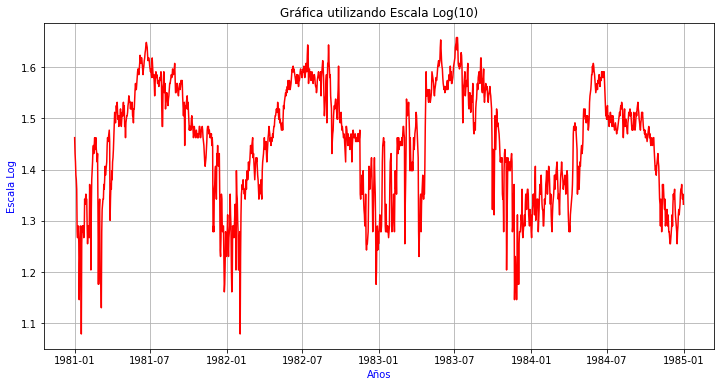

In [ ]:
ts_TmaxLog = np.log10(ts_Tmax)
plt.plot(ts_TmaxLog, color= 'red')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

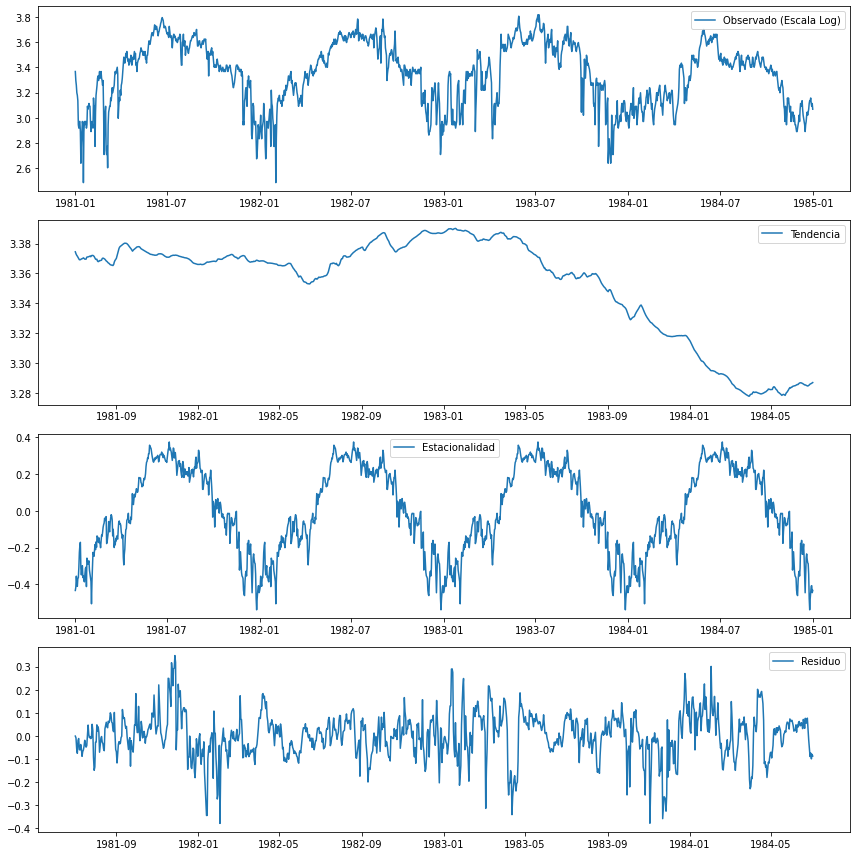

In [ ]:
decompTmax = sm.tsa.seasonal_decompose(Periodo_prueba_ln.interpolate(), model='additive', freq=365)

#La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trendTmax = decompTmax.trend
seasonTmax = decompTmax.seasonal
resTmax = decompTmax.resid

#Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(Periodo_prueba_ln, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trendTmax, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonTmax, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(resTmax, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

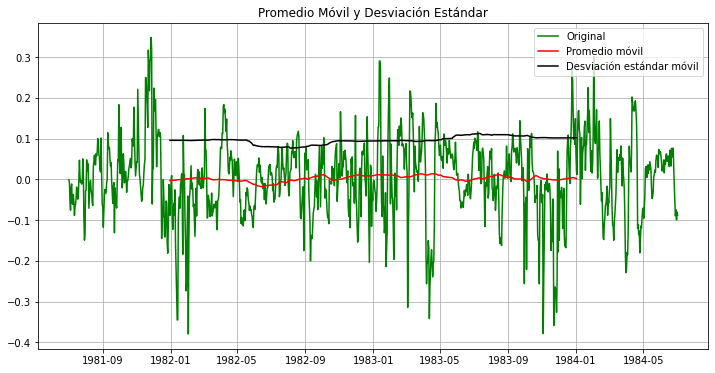

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -5.477362
p-value                           0.000002
#Lags Used                       22.000000
Number of Observations Used    1074.000000
Valor critico (1%)               -3.436453
Valor critico (5%)               -2.864235
Valor critico (10%)              -2.568205
dtype: float64


In [ ]:
Periodo_prueba_decompose = resTmax
Periodo_prueba_decompose.dropna(inplace=True)
test_stationarity(Periodo_prueba_decompose)

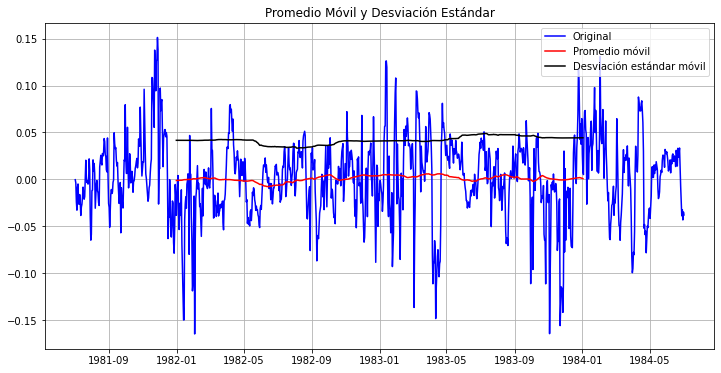

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -5.477362
p-value                           0.000002
#Lags Used                       22.000000
Number of Observations Used    1074.000000
Critical Value (1%)              -3.436453
Critical Value (5%)              -2.864235
Critical Value (10%)             -2.568205
dtype: float64


In [ ]:
resTmax.dropna(inplace=True)
test_stationarity(resTmax)

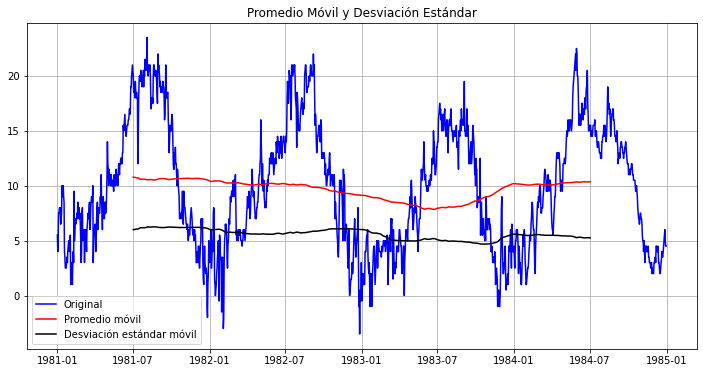

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.031208
p-value                           0.032081
#Lags Used                        4.000000
Number of Observations Used    1456.000000
Critical Value (1%)              -3.434849
Critical Value (5%)              -2.863527
Critical Value (10%)             -2.567828
dtype: float64


In [ ]:
test_stationarity(ts_Tmin)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


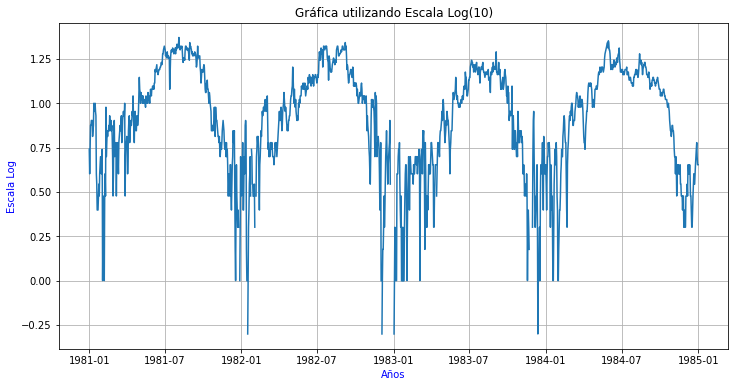

In [ ]:
ts_TminLog = np.log10(ts_Tmin)
plt.plot(ts_TminLog)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

In [ ]:
ts_TmaxLog_diff = Periodo_prueba_ln - Periodo_prueba_ln.shift(periods=7)
ts_TmaxLog_diff.dropna(inplace=True)

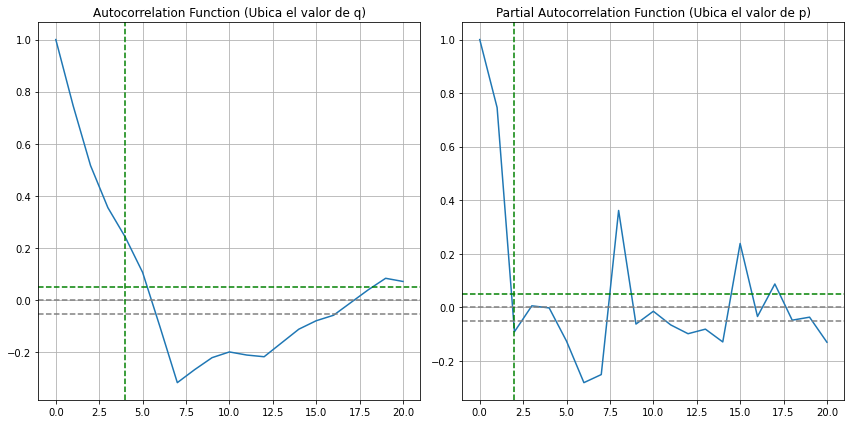

In [ ]:
lag_acf = acf(ts_TmaxLog_diff, nlags=20)
lag_pacf = pacf(ts_TmaxLog_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_TmaxLog_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1460
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1721.760
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sun, 25 Apr 2021   AIC                          -3435.519
Time:                        01:39:04   BIC                          -3414.374
Sample:                    01-02-1981   HQIC                         -3427.631
                         - 12-31-1984                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.002     -0.118      0.906      -0.003       0.003
ar.L1.D.Tmax    -0.0865      0.026     -3.334      0.001      -0.137      -0.036
ar.L2.D.Tmax    -0.1299      0.026     -5.00

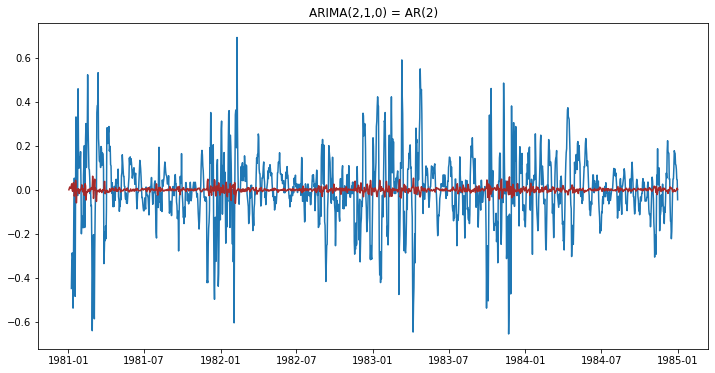

In [ ]:
model = ARIMA(Periodo_prueba_ln, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1460
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1736.584
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sun, 25 Apr 2021   AIC                          -3461.168
Time:                        01:40:35   BIC                          -3429.450
Sample:                    01-02-1981   HQIC                         -3449.336
                         - 12-31-1984                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.001     -0.119      0.905      -0.002       0.002
ma.L1.D.Tmax    -0.1099      0.026     -4.165      0.000      -0.162      -0.058
ma.L2.D.Tmax    -0.1442      0.027     -5.39

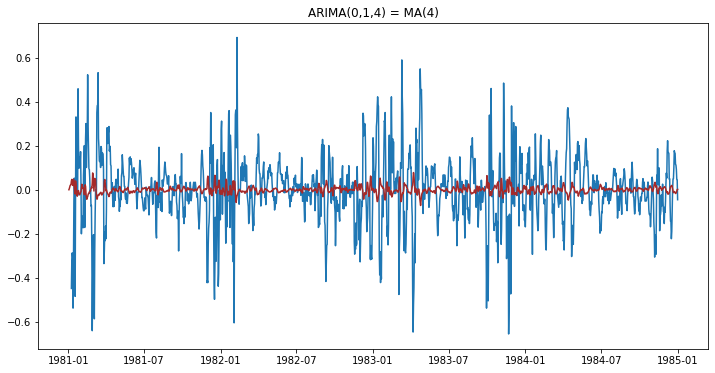

In [ ]:
model = ARIMA(Periodo_prueba_ln, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1453
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1333.047
Method:                       css-mle   S.D. of innovations              0.096
Date:                Sun, 25 Apr 2021   AIC                          -2650.094
Time:                        01:56:23   BIC                          -2607.842
Sample:                    01-09-1981   HQIC                         -2634.328
                         - 12-31-1984                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.719e-06   1.47e-05     -0.456      0.649   -3.56e-05    2.22e-05
ar.L1.D.Tmax    -0.1922      0.030     -6.379      0.000      -0.251      -0.133
ar.L2.D.Tmax    -0.3943      0.026    -15.30

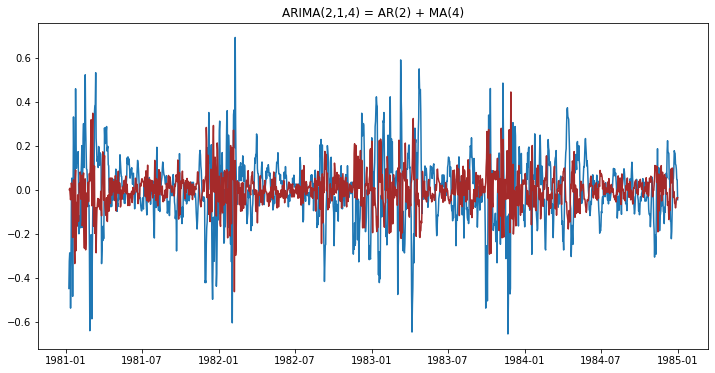

In [ ]:
model = ARIMA(ts_TmaxLog_diff, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_TmaxLog_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1981-01-09   -0.000007
1981-01-10    0.006366
1981-01-11   -0.018394
1981-01-12   -0.045553
1981-01-13   -0.022835
                ...   
1984-12-27   -0.068671
1984-12-28   -0.042088
1984-12-29   -0.037616
1984-12-30   -0.042266
1984-12-31   -0.036183
Length: 1453, dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(Periodo_prueba_ln, index = Periodo_prueba_ln.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
1981-01-01   NaN
1981-01-02   NaN
1981-01-03   NaN
1981-01-04   NaN
1981-01-05   NaN
dtype: float64
Fecha
1984-12-27    3.088329
1984-12-28    3.071428
1984-12-29    3.053427
1984-12-30    3.071250
1984-12-31    3.031870
dtype: float64


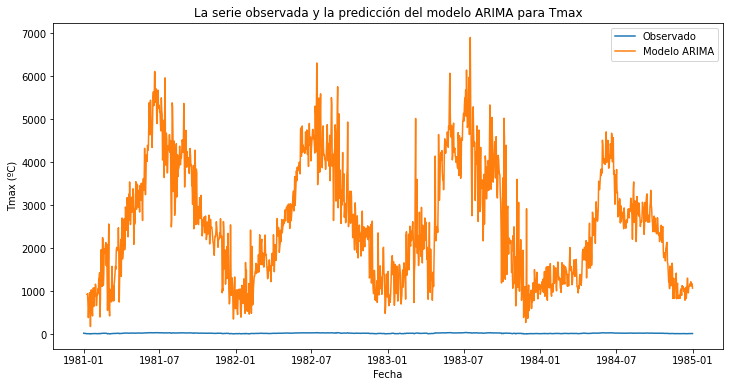

In [ ]:
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

#Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Tmax, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Tmax)**2))
print('RMSE:', RMSE)

RMSE: 2881.2810753434524


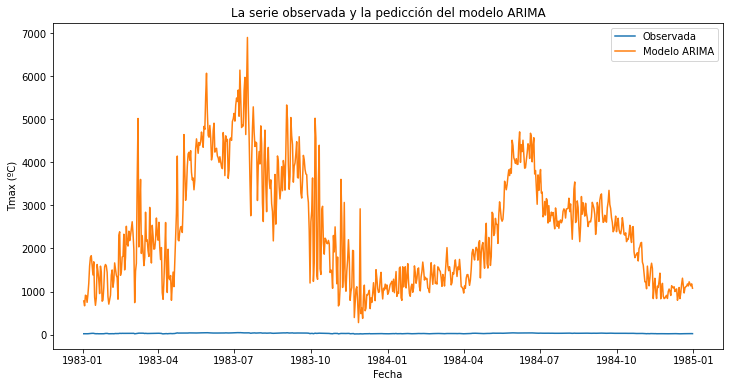

In [ ]:
ts_TmaxLast = ts_Tmax.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_TmaxLast, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la pedicción del modelo ARIMA')
plt.legend(loc='best');
